In [1]:
import os
from dotenv import load_dotenv
import snowflake.connector
import pandas as pd
import plotly.express as px
# Use Plotly's "make_subplots" function from "plotly.subplots" to layout elements horizontally
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Load credentials
load_dotenv()

True

In [2]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account=os.getenv('SNOWFLAKE_ACCOUNT') + '.' + os.getenv('SNOWFLAKE_REGION'),
    warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
    database='WALMART_DB',
    schema='SILVER',
    role=os.getenv('SNOWFLAKE_ROLE')
)

In [3]:
# SQL query
# After an initial run, I saw sales numbers up to 30B.  This seemed very
# high to me. After further investigation, I found that multiple stores
# share the same size.  This means we're aggregating weekly sales across
# multiple stores when the store sizes match. The only way I found to 
# address this was to take the average sales between all stores that had
# the same size.  For stores with no store size duplicates, the weekly
# sales and average weekly sales will be identical.
# sql = """
# SELECT 
#   wsd.store_size,
#   COUNT(wft.store_id) AS store_count,
#   SUM(wft.store_weekly_sales) AS weekly_sales,
#   SUM(wft.store_weekly_sales) / COUNT(wft.store_id) AS avg_sales_per_store
# FROM 
#   walmart_fact_table wft
# JOIN
#   walmart_store_dim wsd
# ON
#   wft.store_id = wsd.store_id
# GROUP BY 1
# ORDER BY 1
# """

# In an attempt to match the area chart included in the project documentation,
# the SQL below was used.
sql = """
SELECT 
    wdd.month_name,
    wsd.store_type,
    SUM(wft.store_weekly_sales) AS weekly_sales
FROM 
    WALMART_DB.SILVER.walmart_fact_table wft
JOIN 
    WALMART_DB.SILVER.walmart_store_dim wsd 
ON 
    wft.store_id = wsd.store_id
JOIN
    WALMART_DB.SILVER.walmart_date_dim wdd
ON
    wft.date_id = wdd.date_id
WHERE 
    wsd.store_size IS NOT NULL
GROUP BY 1,2
ORDER BY MIN(wdd.month),2
"""

# The following SQL is for the summary chart section in the report.

sql_summary_chart = """
SELECT 
    wdd.month_name,
    SUM(CASE WHEN wsd.store_type = 'A' THEN wft.store_weekly_sales ELSE 0 END) AS store_type_a_sales,
    SUM(CASE WHEN wsd.store_type = 'B' THEN wft.store_weekly_sales ELSE 0 END) AS store_type_b_sales,
    SUM(CASE WHEN wsd.store_type = 'C' THEN wft.store_weekly_sales ELSE 0 END) AS store_type_c_sales
FROM 
    WALMART_DB.SILVER.walmart_fact_table wft
JOIN 
    WALMART_DB.SILVER.walmart_store_dim wsd 
ON 
    wft.store_id = wsd.store_id
JOIN
    WALMART_DB.SILVER.walmart_date_dim wdd
ON
    wft.date_id = wdd.date_id
WHERE 
    wsd.store_size IS NOT NULL
GROUP BY 1
ORDER BY MIN(wdd.month)
"""

# Run query using Snowflake connector
cur = conn.cursor()
cur.execute(sql)

# Load results into DataFrame
columns = [col[0] for col in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data, columns=columns)

# Force column names to lowercase so Snowflake will match the model table
df.columns = [col.lower() for col in df.columns]

# print(df.columns)

# Convert the store size to a string 
# plotly create a more managable range for the y-axis
# df['store_size'] = df['store_size'].astype(str)


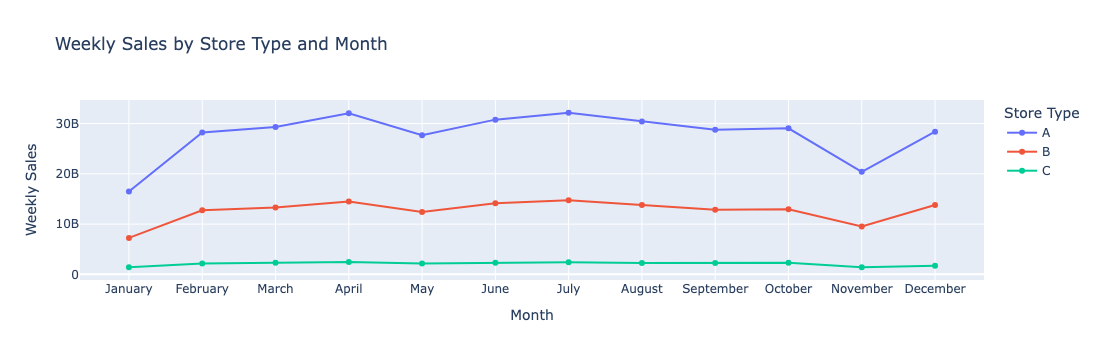

In [4]:
# THIS CHART IS FOR AVERAGE WEEKLY SALES BY STORE TYPE AND MONTH
# Plot using Plotly

# Create some hover text
df['hover_text'] = (
    'Store Type: ' + df['store_type'] +
    '<br>Month: ' + df['month_name'] +
    '<br>Sales: $' + df['weekly_sales'].round(2).map('{:,.2f}'.format)
)

fig = px.line(
    df,
    x='month_name',
    y='weekly_sales',
    color='store_type',
    text='hover_text',  # Use my custom text for the hover
    markers=True,
    title='Weekly Sales by Store Type and Month',
    labels={
        'month_name': 'Month',
        'weekly_sales': 'Weekly Sales',
        'store_type': 'Store Type'
    },
    category_orders={'month_name': ['January', 'February', 'March', 'April', 'May', 'June', 
                                     'July', 'August', 'September', 'October', 'November', 'December']}
)

fig.update_traces(
    hovertemplate='%{text}<extra></extra>',
    mode='lines+markers'
)

fig.show()

In [13]:
df.dtypes

month_name       object
store_type       object
weekly_sales    float64
dtype: object

In [5]:
# This is the summary table
df_summary = pd.read_sql(sql_summary_chart, conn)
# Force column names to lowercase so Snowflake will match the model table
df_summary.columns = [col.lower() for col in df_summary.columns]

df_total_row = pd.DataFrame([{
    'month_name':'Total',
    'store_type_a_sales': df_summary['store_type_a_sales'].sum(),
    'store_type_b_sales': df_summary['store_type_b_sales'].sum(),
    'store_type_c_sales': df_summary['store_type_c_sales'].sum()
}])
df_summary = pd.concat([df_summary, df_total_row], ignore_index=True)

# Make a copy of the dataframe to format the numbers.  The original
# will be used later for the dashboard layout, so the numbers need to
# remain unformatted.
df_summary_formatted = df_summary.copy(deep=True)

# Format the weekly_sales number to look like currency
df_summary_formatted['store_type_a_sales'] = df_summary['store_type_a_sales'].apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
df_summary_formatted['store_type_b_sales'] = df_summary['store_type_c_sales'].apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
df_summary_formatted['store_type_c_sales'] = df_summary['store_type_c_sales'].apply(lambda x: f"${x:,.2f}" if isinstance(x, (int, float)) else x)
print(df_summary_formatted)


/var/folders/90/m9dcfcxn38j0ypf7wjqn_bf80000gp/T/ipykernel_98158/839785212.py:2: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



   month_name   store_type_a_sales  store_type_b_sales  store_type_c_sales
0     January   $16,499,101,314.85   $1,429,844,735.25   $1,429,844,735.25
1    February   $28,244,767,312.56   $2,149,852,757.09   $2,149,852,757.09
2       March   $29,338,085,632.69   $2,294,497,464.02   $2,294,497,464.02
3       April   $32,066,125,525.08   $2,476,406,502.70   $2,476,406,502.70
4         May   $27,666,410,385.63   $2,151,798,254.46   $2,151,798,254.46
5        June   $30,782,718,484.42   $2,290,829,074.32   $2,290,829,074.32
6        July   $32,151,548,629.39   $2,427,462,912.30   $2,427,462,912.30
7      August   $30,429,943,946.20   $2,284,637,949.08   $2,284,637,949.08
8   September   $28,754,182,649.69   $2,282,469,302.52   $2,282,469,302.52
9     October   $29,064,473,069.46   $2,305,314,082.41   $2,305,314,082.41
10   November   $20,410,065,301.94   $1,415,565,800.77   $1,415,565,800.77
11   December   $28,373,522,502.76   $1,722,567,833.81   $1,722,567,833.81
12      Total  $333,780,9

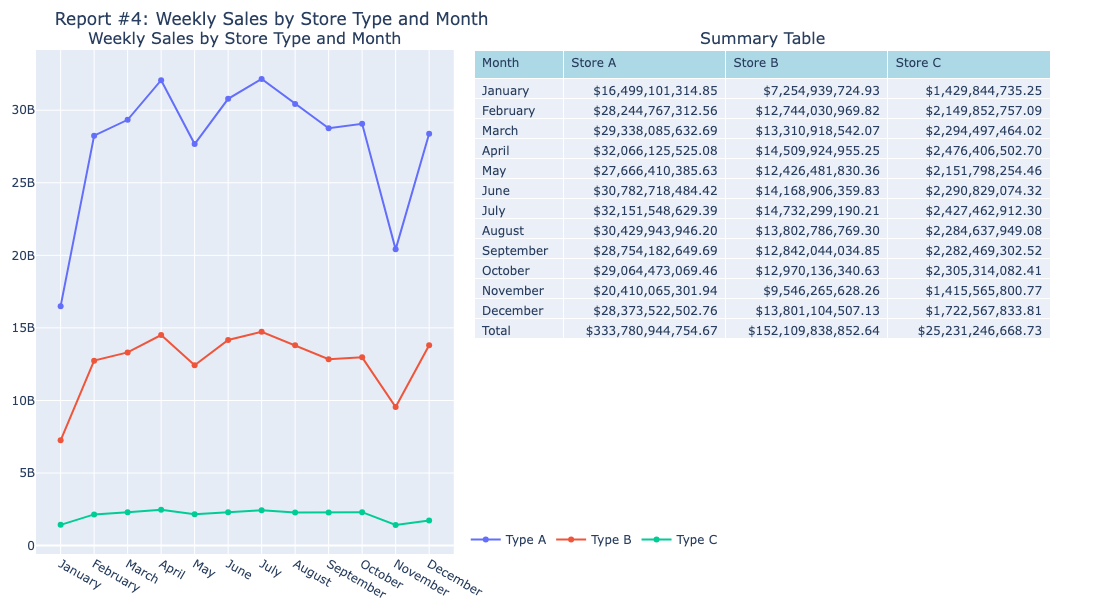

In [6]:
# Let's combine the graph and the summary table into single dashboard-type of presentation

# First, let's layout the overall container for the charts
fig = make_subplots(
    rows=1,
    cols=2,
    column_widths=[0.42,0.58],
    horizontal_spacing=0.02,  # reduce the gutter between col1 and col2
    subplot_titles=("Weekly Sales by Store Type and Month", "Summary Table"),
    specs=[[{"type": "xy"}, {"type": "table"}]]
)

# Next, let's add the line chart to layout column 1
for store_type in df['store_type'].unique():
    df_subset = df[df['store_type'] == store_type]
    fig.add_trace(
        go.Scatter(
            x=df_subset['month_name'],
            y=df_subset['weekly_sales'],
            mode='lines+markers',
            name=f"Type {store_type}",
            text=df_subset['hover_text'],
            hovertemplate="%{text}<extra></extra>"
        ),
        row=1,
        col=1
    )

# Now add the summary table to layout column 2.  Be sure to use the 
# unformatted summary data in df_summary.
fig.add_trace(
    go.Table(
        columnwidth=[22, 40, 40, 40],
        header=dict(
            values=["Month", "Store A", "Store B", "Store C"],
            fill_color="lightblue",
            align="left"
        ),
        cells=dict(
            values=[
                df_summary['month_name'],
                df_summary['store_type_a_sales'],
                df_summary['store_type_b_sales'],
                df_summary['store_type_c_sales']
            ],
            format=["", ",.2f", ",.2f", ",.2f"],
            align=["left", "right","right","right"],
            prefix=["", "$", "$", "$"]
        )
    ),
    row=1,
    col=2
)

# Update layout
fig.update_layout(
    margin=dict(l=20, r=20, t=50, b=20),  # reduce the left/right margin a bit to help with horizontal scrolling
    height=600,
    width=1125,
    title_text="Report #4: Weekly Sales by Store Type and Month",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=0.0,
        xanchor="center",
        x=0.55
    )
)

fig.show()
    


In [ ]:
# Close the connection
conn.close()